In [9]:
import tensorflow as tf
import keras.layers as tkl
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your dataset and split it into training and validation sets
data_dir = '/dataset_resized/'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="validation",
  seed = 1227,
  image_size=(224, 224),
  batch_size=32)

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

val_batches = tf.data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(val_batches // 5)
valid_ds = valid_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Normalize the pixel values of the images to be in the range [-1, 1]
# normalization_layer = tkl.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))



# Use data augmentation to add more data for training
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

inputs = tf.keras.Input(shape=(224, 224, 3))
# Choose a pre-trained model to use as the basis for transfer learning
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model to prevent them from being updated during training
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# The final layer should have as many units as there are classes
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
# Compile the model with a loss function and an optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

base_model.summary()

NotFoundError: Could not find directory /dataset/dataset_resized/

In [6]:
initial_epochs = 100

In [ ]:
callbacks_list = [ModelCheckpoint(filepath='model.hdf5', monitor='val_accuracy',
                                   verbose=1, save_best_only=True, save_weights_only=False, mode='max')]
csv_logger = CSVLogger('modeltraining.log', separator=',', append=False)

# Train the model on the training set
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=(valid_ds),
                    callbacks=(callbacks_list+[csv_logger]))

Epoch 1/100


2022-12-16 07:48:52.139508: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-16 07:48:54.086475: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


64/64 [==============================] - 24s 203ms/step - loss: 1.3735 - accuracy: 0.5608 - val_loss: 0.8571 - val_accuracy: 0.6895

Epoch 00001: val_accuracy improved from -inf to 0.68949, saving model to model.hdf5
Epoch 2/100
64/64 [==============================] - 6s 89ms/step - loss: 0.7710 - accuracy: 0.7186 - val_loss: 0.6134 - val_accuracy: 0.7702

Epoch 00002: val_accuracy improved from 0.68949 to 0.77017, saving model to model.hdf5
Epoch 3/100
64/64 [==============================] - 6s 91ms/step - loss: 0.6691 - accuracy: 0.7547 - val_loss: 0.7069 - val_accuracy: 0.7604

Epoch 00003: val_accuracy did not improve from 0.77017
Epoch 4/100
64/64 [==============================] - 6s 88ms/step - loss: 0.6113 - accuracy: 0.7834 - val_loss: 0.5216 - val_accuracy: 0.8044

Epoch 00004: val_accuracy improved from 0.77017 to 0.80440, saving model to model.hdf5
Epoch 5/100
64/64 [==============================] - 6s 90ms/step - loss: 0.5775 - accuracy: 0.7859 - val_loss: 0.5664 - val_

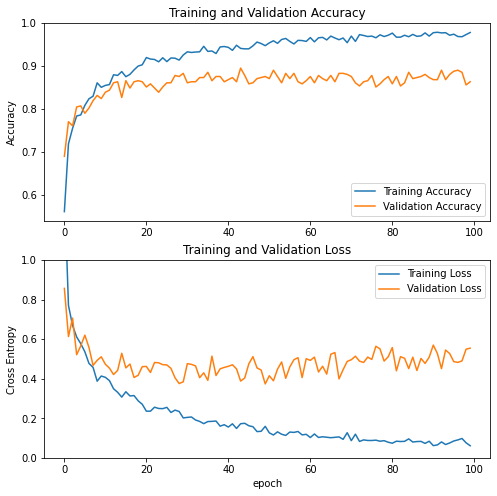

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 11

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  19


In [ ]:
# Unfreeze the base model layers and re-compile the model
base_model.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              104960

In [ ]:
len(model.trainable_variables)

32

In [ ]:
fine_tune_epochs = 200
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
# Fine-tune the model on the training set
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds,
                         callbacks=(callbacks_list+[csv_logger]))

Epoch 100/300
64/64 [==============================] - 18s 241ms/step - loss: 0.0870 - accuracy: 0.9693 - val_loss: 0.6451 - val_accuracy: 0.8631

Epoch 00100: val_accuracy did not improve from 0.89487
Epoch 101/300
64/64 [==============================] - 15s 227ms/step - loss: 0.0838 - accuracy: 0.9703 - val_loss: 0.5978 - val_accuracy: 0.8631

Epoch 00101: val_accuracy did not improve from 0.89487
Epoch 102/300
64/64 [==============================] - 15s 228ms/step - loss: 0.0784 - accuracy: 0.9723 - val_loss: 0.5235 - val_accuracy: 0.8826

Epoch 00102: val_accuracy did not improve from 0.89487
Epoch 103/300
64/64 [==============================] - 15s 228ms/step - loss: 0.0993 - accuracy: 0.9708 - val_loss: 0.4505 - val_accuracy: 0.8924

Epoch 00103: val_accuracy did not improve from 0.89487
Epoch 104/300
64/64 [==============================] - 15s 229ms/step - loss: 0.0699 - accuracy: 0.9773 - val_loss: 0.4970 - val_accuracy: 0.8924

Epoch 00104: val_accuracy did not improve fro

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

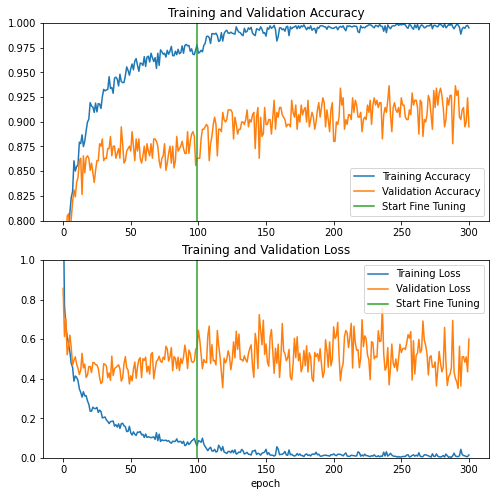

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(test_ds)
print('Validation loss: {}, Validation accuracy: {}'.format(val_loss, val_acc))

3/3 [==============================] - 1s 69ms/step - loss: 0.6590 - accuracy: 0.8646
Validation loss: 0.6589545011520386, Validation accuracy: 0.8645833134651184


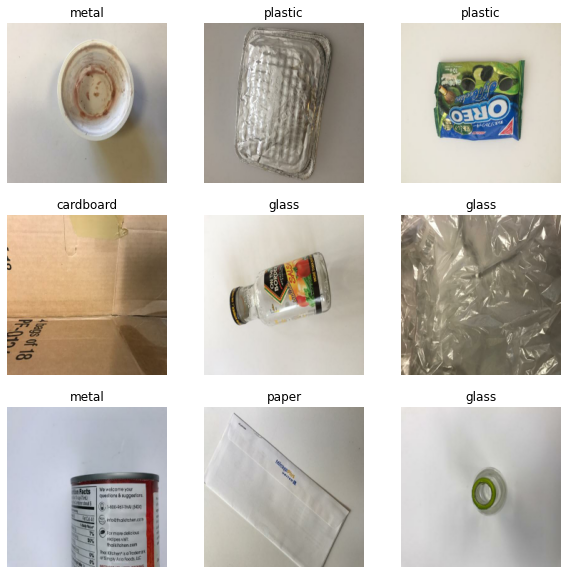

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")